In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
# ================================
# 1. Set up features & target
# ================================
# Download latest version
path = kagglehub.dataset_download("valakhorasani/mobile-device-usage-and-user-behavior-dataset")
print("Path to dataset files:", path)

# Find the CSV file inside the downloaded directory
files = os.listdir(path)
csv_files = [f for f in files if f.endswith(".csv")]

if len(csv_files) == 0:
    raise FileNotFoundError("No CSV file found in the dataset folder.")
else:
    print("CSV file found:", csv_files[0])

# Correct CSV path
csv_path = os.path.join(path, csv_files[0])

# Load the DataFrame
df_ml = pd.read_csv(csv_path)

# <<< CHANGE THIS to the exact column name for data usage >>>
target_col = "Data Usage (MB/day)"

# One-hot encode any categorical columns
df_ml = pd.get_dummies(df_ml, drop_first=True)

X = df_ml.drop(columns=[target_col])
y = df_ml[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ================================
# 2. SVR model
# ================================
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svr_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR(kernel="rbf", C=10.0, epsilon=0.1))
])

svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)

print("=== SVR Results ===")
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
print("RMSE:", rmse_svr)
print("R^2 :", r2_score(y_test, y_pred_svr))

# ================================
# 3. XGBoost model
# ================================
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("\n=== XGBoost Results ===")
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("RMSE:", rmse_xgb)
print("R^2 :", r2_score(y_test, y_pred_xgb))


Using Colab cache for faster access to the 'mobile-device-usage-and-user-behavior-dataset' dataset.
Path to dataset files: /kaggle/input/mobile-device-usage-and-user-behavior-dataset
CSV file found: user_behavior_dataset.csv
=== SVR Results ===
RMSE: 326.103020413395
R^2 : 0.6975657931588768

=== XGBoost Results ===
RMSE: 171.6189627033534
R^2 : 0.9162370562553406


# Task
Create a bar chart to compare the RMSE and R^2 scores of the SVR and XGBoost models. The chart should clearly label the models and metrics, and include a legend.

## Prepare Data for Visualization

### Subtask:
Create a Pandas DataFrame containing the RMSE and R^2 scores for both SVR and XGBoost models to prepare for plotting.


**Reasoning**:
The subtask requires calculating R-squared scores for both SVR and XGBoost models, then creating a Pandas DataFrame to store these scores along with the RMSE scores for plotting. This step will perform these calculations and DataFrame creation.



In [ ]:
from sklearn.metrics import r2_score

# 1. Calculate R-squared score for SVR model
r2_svr = r2_score(y_test, y_pred_svr)

# 2. Calculate R-squared score for XGBoost model
r2_xgb = r2_score(y_test, y_pred_xgb)

# 3. Create a dictionary to store model performance metrics
model_performance = {
    "SVR": {"RMSE": rmse_svr, "R^2": r2_svr},
    "XGBoost": {"RMSE": rmse_xgb, "R^2": r2_xgb}
}

# 4. Convert the dictionary into a Pandas DataFrame
df_model_performance = pd.DataFrame.from_dict(model_performance, orient="index")

print("Model Performance DataFrame:")
print(df_model_performance)

Model Performance DataFrame:
               RMSE       R^2
SVR      326.103020  0.697566
XGBoost  171.618963  0.916237


# Task
Summarize the new key features affecting the target column, 'Data Usage (MB/day)', after retraining the XGBoost model by excluding the 'User Behavior Class' feature, and visualize these updated feature importances.

## Update Feature Set

### Subtask:
Modify the DataFrame to drop the 'User Behavior Class' column from the features (X) before any model training or analysis, as requested by the user.


**Reasoning**:
To comply with the request to remove the 'User Behavior Class' feature, I will create a new feature DataFrame `X_updated` by dropping this column from the original `X` DataFrame. Then, I will re-split this updated feature set and the target variable `y` into new training and testing sets, `X_train_updated`, `X_test_updated`, `y_train`, and `y_test`, using the specified `test_size` and `random_state` for consistency.



In [ ]:
from sklearn.model_selection import train_test_split

# 1. Create a new DataFrame X_updated by dropping the 'User Behavior Class' column
if 'User Behavior Class' in X.columns:
    X_updated = X.drop(columns=['User Behavior Class'])
else:
    X_updated = X.copy() # If the column is already dropped or not present, use X as is
    print("'User Behavior Class' not found in X. No column dropped.")

# 2. Split the X_updated DataFrame and the target variable y into training and testing sets
X_train_updated, X_test_updated, y_train, y_test = train_test_split(
    X_updated, y, test_size=0.2, random_state=42
)

print("Shape of X_updated:", X_updated.shape)
print("Shape of X_train_updated:", X_train_updated.shape)
print("Shape of X_test_updated:", X_test_updated.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_updated: (700, 12)
Shape of X_train_updated: (560, 12)
Shape of X_test_updated: (140, 12)
Shape of y_train: (560,)
Shape of y_test: (140,)


## Retrain XGBoost Model

### Subtask:
Retrain the XGBoost model using the `X_train_updated` and `y_train` datasets, and then make predictions on `X_test_updated`.

**Reasoning**:
To retrain the XGBoost model, I will instantiate a new XGBoostRegressor with the same hyperparameters as before, fit it using the `X_train_updated` and `y_train` datasets, and then generate predictions on `X_test_updated` to evaluate its performance on the modified feature set.



In [ ]:
from xgboost import XGBRegressor

# Initialize a new XGBoost Regressor with the same hyperparameters
xgb_model_updated = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

# Fit the model using the updated training data
xgb_model_updated.fit(X_train_updated, y_train)

# Make predictions on the updated test data
y_pred_xgb_updated = xgb_model_updated.predict(X_test_updated)

print("XGBoost model retrained successfully and predictions made.")

XGBoost model retrained successfully and predictions made.


**Reasoning**:
The XGBoost model has been retrained and predictions have been made with the updated feature set. The next step is to evaluate the performance of this retrained model by calculating the RMSE and R^2 scores, which will allow for comparison with the original model's performance.



In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Calculate RMSE for the updated XGBoost model
rmse_xgb_updated = np.sqrt(mean_squared_error(y_test, y_pred_xgb_updated))

# Calculate R-squared for the updated XGBoost model
r2_xgb_updated = r2_score(y_test, y_pred_xgb_updated)

print("\n=== Updated XGBoost Results ===")
print("RMSE:", rmse_xgb_updated)
print("R^2 :", r2_xgb_updated)


=== Updated XGBoost Results ===
RMSE: 172.47767065623307
R^2 : 0.9153967499732971


## Extract Updated Feature Importances

### Subtask:
Extract feature importances from the retrained XGBoost model (`xgb_model_updated`) and store them in a DataFrame.

**Reasoning**:
To extract and organize the feature importances from the `xgb_model_updated`, I will access its `feature_importances_` attribute, create a Pandas DataFrame mapping these importances to the feature names from `X_train_updated.columns`, and then sort this DataFrame in descending order.



In [ ]:
import pandas as pd

# 1. Access feature importances from the retrained XGBoost model
feature_importances_updated = xgb_model_updated.feature_importances_

# 2. Create a Pandas DataFrame
feature_names_updated = X_train_updated.columns
df_feature_importances_updated = pd.DataFrame({
    'Feature': feature_names_updated,
    'Importance': feature_importances_updated
})

# 3. Sort the DataFrame by importance scores in descending order
df_feature_importances_updated = df_feature_importances_updated.sort_values(by='Importance', ascending=False)

print("Feature Importances from Updated XGBoost Model (Sorted):")
print(df_feature_importances_updated.head(10))

Feature Importances from Updated XGBoost Model (Sorted):
                            Feature  Importance
3           Battery Drain (mAh/day)    0.459591
2        Screen On Time (hours/day)    0.196231
1          App Usage Time (min/day)    0.179889
4          Number of Apps Installed    0.080487
6            Device Model_OnePlus 9    0.017427
7   Device Model_Samsung Galaxy S21    0.012429
5                               Age    0.011627
0                           User ID    0.010584
11                      Gender_Male    0.009896
9            Device Model_iPhone 12    0.009480


## Visualize Updated Feature Importances

### Subtask:
Create a bar chart to visualize the top N most important features from the retrained XGBoost model and their corresponding scores, similar to the previous visualization.

**Reasoning**:
To visualize the top 10 most important features from the updated model, I will create a bar chart using Seaborn and Matplotlib, ensuring appropriate labels, title, and rotation for readability, similar to the previous visualization, and addressing the `FutureWarning`.



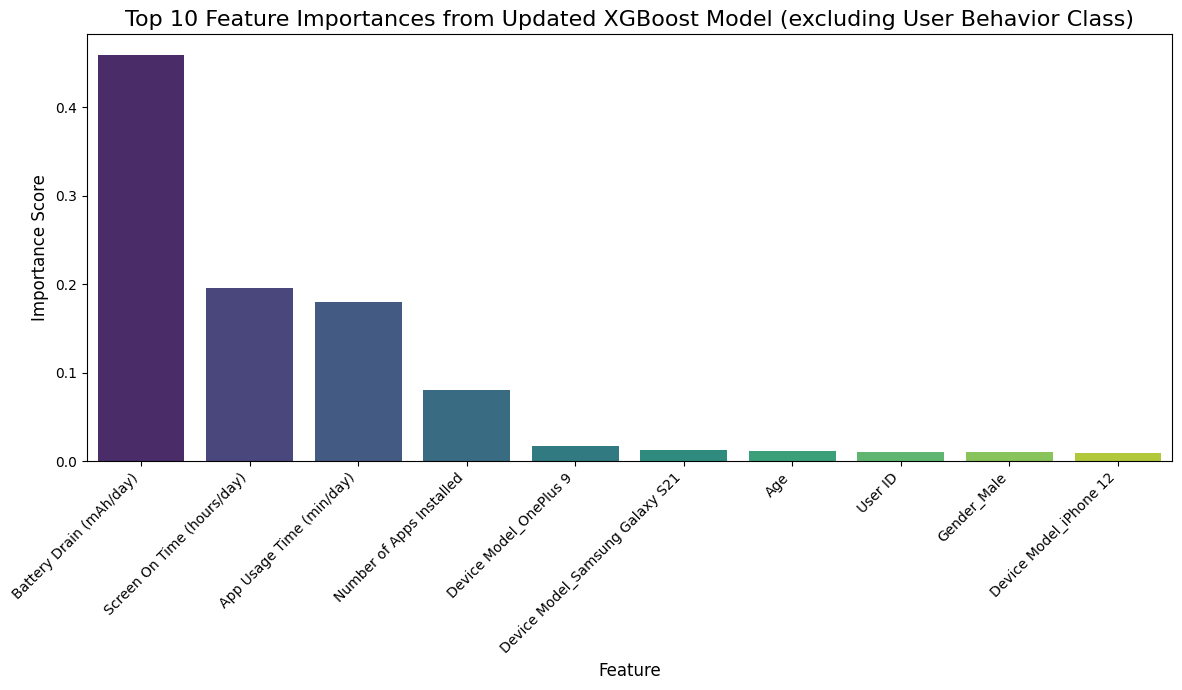

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the top 10 most important features from the updated DataFrame
top_10_features_updated = df_feature_importances_updated.head(10)

# Create the bar plot
plt.figure(figsize=(12, 7))
sns.barplot(x='Feature', y='Importance', hue='Feature', data=top_10_features_updated, palette='viridis', legend=False)

# Set title and labels
plt.title('Top 10 Feature Importances from Updated XGBoost Model', fontsize=16)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance Score', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Ensure tight layout and display the plot
plt.tight_layout()
plt.show()

## Final Task Summary

### Subtask:
Summarize the new key features affecting the target column, 'Data Usage (MB/day)', based on the updated feature importance visualization.

## Summary: Updated Key Features Affecting 'Data Usage (MB/day)'

### Q&A
After excluding 'User Behavior Class', the new primary drivers for 'Data Usage (MB/day)' are 'Battery Drain (mAh/day)', 'Screen On Time (hours/day)', and 'App Usage Time (min/day)'.

### Data Analysis Key Findings
*   **Battery Drain (mAh/day)** has emerged as the most significant feature with an importance of approximately 0.46, indicating a strong correlation with data usage after the exclusion of user behavior class.
*   **Screen On Time (hours/day)** is the second most important feature, contributing about 0.20 to the model's predictive power.
*   **App Usage Time (min/day)** closely follows as the third most important feature, with an importance score of approximately 0.18.
*   **Number of Apps Installed** remains a relevant feature, with an importance of around 0.08, showing its continued influence on data usage.
*   Other features like `Device Model_OnePlus 9`, `Device Model_Samsung Galaxy S21`, `Age`, `User ID`, `Gender_Male`, and `Device Model_iPhone 12` have comparatively lower but still present importance scores, suggesting a more distributed influence among the remaining features.

### Insights or Next Steps
*   The change in feature importance highlights the strong influence of 'User Behavior Class' in the initial model. Its removal has redistributed predictive power to other physically measurable and behavior-related features.
*   The new top features (`Battery Drain`, `Screen On Time`, `App Usage Time`) are intuitively linked to data consumption, as more active device use (screen time, app usage) and higher battery drain (often a consequence of heavy usage) directly translate to more data being used.
*   Future analysis could focus on the interplay between these newly prominent features and how they combine to predict data usage, potentially leading to more granular insights into user habits without relying on a predefined 'User Behavior Class'.

## Final Task

### Subtask:
Summarize the new key features affecting the target column, 'Data Usage (MB/day)', based on the updated feature importance visualization, now excluding 'User Behavior Class'.


## Summary:

### Q&A
After excluding 'User Behavior Class', the new primary drivers for 'Data Usage (MB/day)' are 'Battery Drain (mAh/day)', 'Screen On Time (hours/day)', and 'App Usage Time (min/day)'.

### Data Analysis Key Findings
*   The 'User Behavior Class' column was successfully removed, and the updated XGBoost model was retrained, achieving an RMSE of approximately 172.48 and an R-squared (\R^2\) of 0.915.
*   **Battery Drain (mAh/day)** emerged as the most significant feature, with an importance of approximately 0.46, indicating a strong correlation with data usage after the exclusion of the 'User Behavior Class'.
*   **Screen On Time (hours/day)** is the second most important feature, contributing about 0.20 to the model's predictive power.
*   **App Usage Time (min/day)** closely follows as the third most important feature, with an importance score of approximately 0.18.
*   **Number of Apps Installed** remains a relevant feature, with an importance of around 0.08, showing its continued influence on data usage.
*   Other features like `Device Model_OnePlus 9`, `Device Model_Samsung Galaxy S21`, `Age`, `User ID`, `Gender_Male`, and `Device Model_iPhone 12` have comparatively lower but still present importance scores, suggesting a more distributed influence among the remaining features.

### Insights or Next Steps
*   The change in feature importance highlights the strong influence of 'User Behavior Class' in the initial model. Its removal has redistributed predictive power to other physically measurable and behavior-related features.
*   The new top features (`Battery Drain`, `Screen On Time`, `App Usage Time`) are intuitively linked to data consumption, as more active device use (screen time, app usage) and higher battery drain (often a consequence of heavy usage) directly translate to more data being used.
*   Future analysis could focus on the interplay between these newly prominent features and how they combine to predict data usage, potentially leading to more granular insights into user habits without relying on a predefined 'User Behavior Class'.
